# NN with Hold out CV

In [52]:
import numpy as np
from pytorch_lightning.callbacks import LearningRateMonitor
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from pytorch_lightning.callbacks import ModelSummary
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from pytorch_lightning.loggers import CSVLogger
import torch
import pandas as pd
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader 
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchmetrics import Accuracy

In [53]:
monk1_train = pd.read_csv('data/monks-1.train',header=None,sep=" ")
monk1_test = pd.read_csv('data/monks-1.test',header=None,sep=" ")

In [54]:
monk1_train.drop(0,axis=1,inplace=True)
monk1_train.drop(8,axis=1,inplace=True)

monk1_test.drop(0,axis=1,inplace=True)
monk1_test.drop(8,axis=1,inplace=True)

In [55]:
xtr = monk1_train.iloc[:,1:]
ytr = monk1_train.iloc[:,0]

xts = monk1_test.iloc[:,1:]
yts = monk1_test.iloc[:,0]

In [56]:
type(xtr)

pandas.core.frame.DataFrame

In [57]:
scaler = MinMaxScaler()
xtr = scaler.fit_transform(xtr)
xts = scaler.fit_transform(xts)

In [58]:
xtr, xvl, ytr, yvl = train_test_split(xtr, ytr, test_size=0.10, shuffle=True, random_state=42)

In [59]:
ytr = ytr.to_numpy()
yvl = yvl.to_numpy()

In [60]:
class ClassificationMonk(pl.LightningModule):
    def __init__(self, input_dim, output_dim, hidden1, learning_rate):
        super(ClassificationMonk, self).__init__()
        # First hidden layer
        self.linear1 = nn.Linear(input_dim, hidden1)
        self.act1 = nn.ReLU()
        # Second hidden layer
        self.linear2 = nn.Linear(hidden1, hidden1)
        self.act2 = nn.ReLU()
        # Third hidden layer
        self.linear3 = nn.Linear(hidden1,output_dim)
        self.act3 = nn.Sigmoid()
        self.loss_fun = nn.MSELoss()
        self.dicts = []
        self.learning_rate = learning_rate
        self.apply(self.init_weights)
    
    def init_weights(self,m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)
    
    def forward(self, X):
        #Input to the first hidden layer
        X = self.linear1(X)
        X = self.act1(X)
        # Second hidden layer
        X = self.linear2(X)
        X = self.act2(X)
        # Third hidden layer
        X = self.linear3(X)
        X = self.act3(X)
        return X

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        X, y = train_batch 
        y_copy = y # Integer y for the accuracy
        X = X.type(torch.float32)
        y = y.type(torch.float32)  
        # forward pass
        y_pred = self.forward(X).squeeze()  
        # accuracy
        accuracy = Accuracy()
        acc = accuracy(y_pred, y_copy)
        # compute loss
        loss = self.loss_fun(y_pred, y)
        self.log_dict({'train_loss': loss, 'train_accuracy': acc}, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, validation_batch, batch_idx):
        X, y = validation_batch
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X).squeeze()        
        # compute metrics 
        accuracy = Accuracy()
        acc = accuracy(y_pred, y)
        loss = self.loss_fun(y_pred, y)
        self.log_dict({'validation_loss': loss, 'validation_accuracy': acc}, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    
    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X).squeeze()        
        # compute metrics   
        accuracy = Accuracy()
        acc = accuracy(y_pred, y)
        loss = self.loss_fun(y_pred, y)
        self.log_dict({'test_loss': loss, 'test_accuracy': acc}, on_epoch=False,on_step=True, prog_bar=True, logger=True)
        return loss

In [61]:
hidden1 = 20
max_epochs = 500  
lr = 0.05248074602497723 #found with auto_lr_find=True
train_batch_size = 20 
validation_batch_size = 20
test_batch_size = 20 

In [62]:
# model instance
input_dim = xtr.shape[1]
model = ClassificationMonk(input_dim=input_dim, output_dim=1, hidden1=hidden1, learning_rate=lr)

/var/folders/tz/9k5bcs_502z2svd2fr_k2w680000gn/T/ipykernel_1071/1119856397.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


In [63]:
class ClassificationMonkDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [64]:
train_loader = DataLoader(dataset = ClassificationMonkDataset(xtr, ytr), batch_size=train_batch_size)
validation_loader = DataLoader(dataset = ClassificationMonkDataset(xvl, yvl), batch_size=validation_batch_size)
test_loader = DataLoader(dataset = ClassificationMonkDataset(xts, yts), batch_size=test_batch_size)

In [65]:
# early stopping
early_stop_callback = EarlyStopping(monitor="train_loss", min_delta=0.0001, patience=5, verbose=True, mode="min")

In [66]:
trainer = pl.Trainer(accelerator='cpu', devices=1, max_epochs=max_epochs,callbacks=[early_stop_callback],log_every_n_steps=5,logger=CSVLogger(save_dir="logs/"))  

# for auto lr find
#trainer.tune(model=model, train_dataloaders=train_loader) #for auto_lr_finder

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [67]:
trainer.fit(model=model, train_dataloaders=train_loader) 

/Users/dylan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name     | Type    | Params
-------------------------------------
0 | linear1  | Linear  | 140   
1 | act1     | ReLU    | 0     
2 | linear2  | Linear  | 420   
3 | act2     | ReLU    | 0     
4 | linear3  | Linear  | 21    
5 | act3     | Sigmoid | 0     
6 | loss_fun | MSELoss | 0     
-------------------------------------
581       Trainable params
0         Non-trainable params
581       Total params
0.002     Total estimated model params size (MB)
/Users/dylan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_work

Training: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.243
Metric train_loss improved by 0.027 >= min_delta = 0.0001. New best score: 0.215
Metric train_loss improved by 0.044 >= min_delta = 0.0001. New best score: 0.172
Metric train_loss improved by 0.015 >= min_delta = 0.0001. New best score: 0.156
Metric train_loss improved by 0.010 >= min_delta = 0.0001. New best score: 0.147
Metric train_loss improved by 0.034 >= min_delta = 0.0001. New best score: 0.113
Metric train_loss improved by 0.015 >= min_delta = 0.0001. New best score: 0.097
Metric train_loss improved by 0.018 >= min_delta = 0.0001. New best score: 0.080
Metric train_loss improved by 0.025 >= min_delta = 0.0001. New best score: 0.055
Metric train_loss improved by 0.024 >= min_delta = 0.0001. New best score: 0.031
Metric train_loss improved by 0.010 >= min_delta = 0.0001. New best score: 0.020
Metric train_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.016
Metric train_loss improved by 0.001 >= min_delta = 0.0001. 

In [68]:
trainer.validate(model=model, dataloaders=validation_loader)

/Users/dylan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   validation_accuracy              1.0
     validation_loss      0.00012240310024935752
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'validation_loss': 0.00012240310024935752, 'validation_accuracy': 1.0}]

In [69]:
trainer.test(model=model, dataloaders=test_loader)

/Users/dylan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

[{}]

In [70]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
#del metrics["step"]
metrics

,train_loss,train_accuracy,epoch,step,validation_loss,validation_accuracy,test_loss,test_accuracy
0,0.242908,0.513514,0.0,5,NaN,NaN,NaN,NaN
1,0.215415,0.657658,1.0,11,NaN,NaN,NaN,NaN
2,0.171636,0.747748,2.0,17,NaN,NaN,NaN,NaN
3,0.156405,0.747748,3.0,23,NaN,NaN,NaN,NaN
4,0.146547,0.765766,4.0,29,NaN,NaN,NaN,NaN
5,0.112763,0.819820,5.0,35,NaN,NaN,NaN,NaN
6,0.097472,0.828829,6.0,41,NaN,NaN,NaN,NaN
7,0.079870,0.873874,7.0,47,NaN,NaN,NaN,NaN
8,0.054732,0.936937,8.0,53,NaN,NaN,NaN,NaN
9,0.030708,0.990991,9.0,59,NaN,NaN,NaN,NaN


<function matplotlib.pyplot.show(close=None, block=None)>

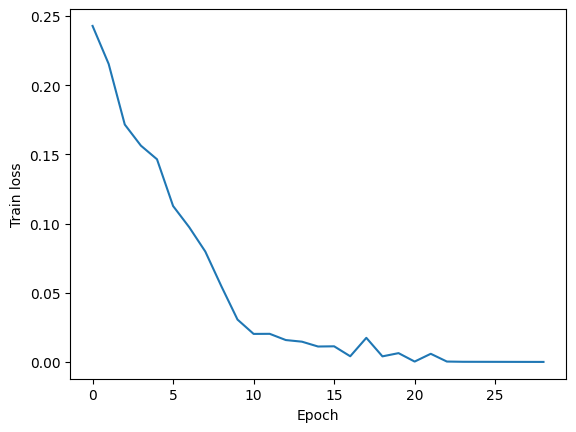

In [71]:
plt.xlabel("Epoch")
plt.ylabel("Train loss")
plt.plot(metrics["train_loss"])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

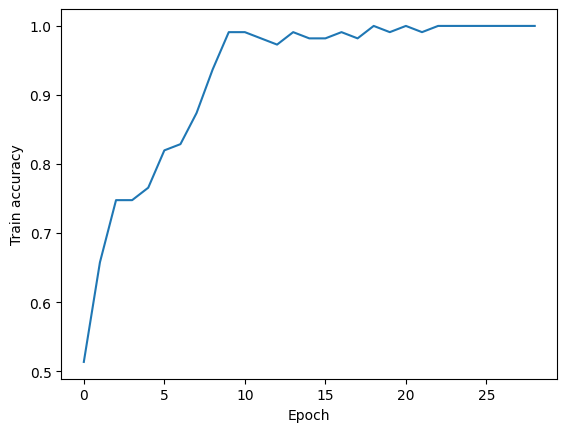

In [72]:
plt.xlabel("Epoch")
plt.ylabel("Train accuracy")
plt.plot(metrics["train_accuracy"])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

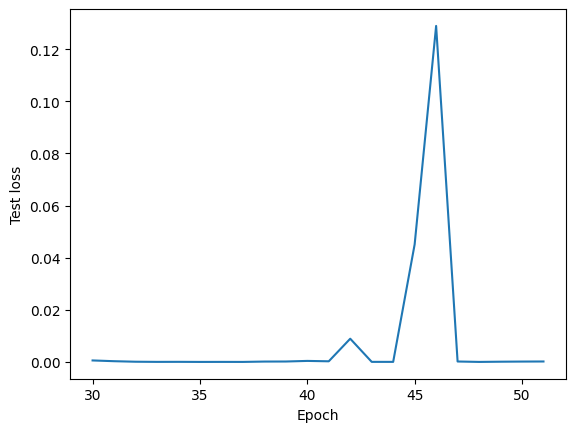

In [73]:
plt.xlabel("Epoch")
plt.ylabel("Test loss")
plt.plot(metrics["test_loss"])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

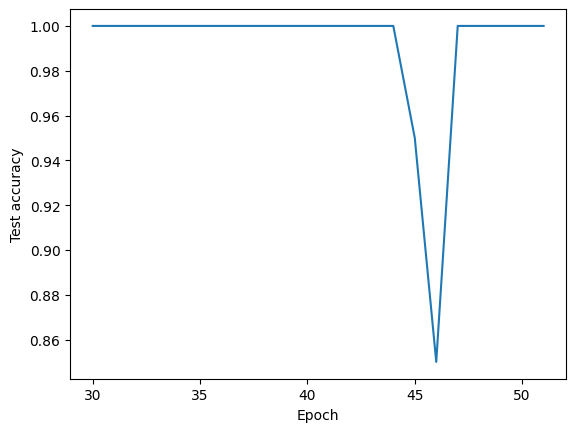

In [74]:
plt.xlabel("Epoch")
plt.ylabel("Test accuracy")
plt.plot(metrics["test_accuracy"])
plt.show